<a href="https://colab.research.google.com/github/cesar-claros/synergistic/blob/SocialAds/CIFAR10_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR 10

In [1]:
! git clone https://github.com/cesar-claros/synergistic
% cd synergistic/

Cloning into 'synergistic'...
remote: Enumerating objects: 269, done.
remote: Counting objects: 100% (269/269), done.
remote: Compressing objects: 100% (250/250), done.
remote: Total 269 (delta 120), reused 51 (delta 16), pack-reused 0
Receiving objects: 100% (269/269), 19.70 MiB | 9.60 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/content/synergistic


## Dependencies

In [2]:
#%%
# Command line instalation
# ---------------------------
!pip install torch
!pip install gpytorch
!pip install tensorflow-determinism

# Imports
# ---------------------------
import io #Used as buffer
import sys
import matplotlib
import tensorflow as tf # Keras model for MNIST 
# matplotlib.use('qt5Agg')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import auxfunc.funcs as sgn
import auxfunc.trustscore as trs
import seaborn as sns
import torch
from scipy.stats import entropy, spearmanr
from sklearn import model_selection, svm, ensemble, linear_model, pipeline, metrics,\
      tree, neighbors, discriminant_analysis, gaussian_process, preprocessing, impute, decomposition
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
plt.style.use(['ggplot','style/style.mplstyle'])
import os
import random

     |████████████████████████████████| 503 kB 4.3 MB/s 
  Created wheel for tensorflow-determinism: filename=tensorflow_determinism-0.3.0-py3-none-any.whl size=9157 sha256=db57b4969c394fc013af311cd98e6bb33c7fd47e329773501748bcafaf929751
  Stored in directory: /root/.cache/pip/wheels/d2/be/33/2b27e81e5d40b4bfb7c103ac6c6c5e81fdbcf40d2af5078529
Successfully built tensorflow-determinism


## Auxiliar Functions

In [3]:
#%%
# Define classic MLP architecture
def CNN_model(input_dim):
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(32,32,3))) 
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model

In [4]:
#%%
# Signaling function fitting and evaluation
def signalingFunction(X_train, y_train, y_train_pred_th, X_val, y_val, y_val_pred_th, X_test, y_test, y_test_pred_th, kernel='exponential', norm='l01', ex_dim=1):
    # X_train, X_val should be scaled. ex_dim=1 by default on sgn.signailing
    # Fit signaling function 
    exp = sgn.signaling(norm=norm) # idx = [train,test,val]
    exp.fit(X_train, y_train, y_train_pred_th, kernel=kernel, n_iter=500, lr=0.01, ex_dim=ex_dim)
    table_val = exp.evaluate(X_val, y_val, y_val_pred_th, rule_grid=np.linspace(0,3,30, endpoint=False), rho_grid=[0.1, 0.15])
    table_test = exp.test(X_test, y_test, y_test_pred_th, table_val['rule'].to_numpy(), table_val['eta'].to_numpy())
    table = pd.concat([table_val,table_test],axis=1)
    return table, exp

In [5]:
#%%
# Initialize model
def init_model(input_dim):
    # svm = False
    # model = MLP_model(input_dim=Data_X.shape[1], svm_obj=svm)
    model  = CNN_model(input_dim=input_dim)
    loss   = tf.keras.losses.categorical_crossentropy
    metric = ['accuracy']
    model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, 
                                                     beta_2=0.999, epsilon=1e-07, amsgrad=False,
                                                     name='Adam'),
                  metrics=metric)
    return model

In [6]:
#%%
# Soft and thresholded output predictions
def pred_output(model, X):
    y_pred_soft = model.predict(X)
    y_pred_th   = np.argmax(y_pred_soft, axis=1)
    return y_pred_soft, y_pred_th

In [7]:
#%%
# Jaccard similarity index
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [8]:
#%%
# Baseline comparison
def baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp,trust_val, trust_test):
      direction = 'further'
      # p_val = np.concatenate(y_val_pred_soft,axis=1)
      crit_val   = entropy(y_val_pred_soft, axis=1, base=10)
      # p_test = np.concatenate(y_test_pred_soft,axis=1)
      crit_test  = entropy(y_test_pred_soft, axis=1, base=10)
      # Criteria 1
      critFunc   = sgn.critEvaluation(norm='l01',direction=direction)
      d_val      = critFunc.evaluate(y_val, y_val_pred_th, crit_val, rho_grid=[0.1, 0.15])
      d_test     = critFunc.test(y_test, y_test_pred_th, crit_test, d_val['thresh'].to_numpy())
      crit_table = pd.concat([d_val,d_test],axis=1)
      # Best rules from signailing function on val are used to get UCBs on test
      gamma      = table['rule'].to_numpy().reshape(-1,1)
      f_test     = exp.gpr_mean_test + gamma*np.sqrt(exp.gpr_var_test)
      # Threshold values on val data. UCB Signailing (eta) and new criteria (theta) 
      eta        = table['eta'].to_numpy().reshape(-1,1)
      theta      = crit_table['thresh'].to_numpy().reshape(-1,1)
      if direction == 'closer':
        crit_mask, crit_idx = np.nonzero(crit_test.reshape(1,-1)<theta)
      else:
        crit_mask, crit_idx = np.nonzero(crit_test.reshape(1,-1)>theta)
      f_mask, f_idx = np.nonzero(f_test>eta)      
      shared = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask))))
      # Jaccard index btw signaled instances using both methods for ith rule-threshold
      J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan for i in range(f_test.shape[0])]
      crit_table['jaccard']=J
      Sp = [spearmanr(f_test[i,:],crit_test)[0] for i in range(f_test.shape[0])]
      crit_table['spearman'] = Sp
      crit_table['gamma']    = gamma

      # Criteria 2
      critFuncSc = sgn.critEvaluation(norm='l01',direction='closer')
      s_val      = critFuncSc.evaluate(y_val, y_val_pred_th, trust_val, rho_grid=[0.1, 0.15])
      s_test     = critFuncSc.test(y_test, y_test_pred_th, trust_test, s_val['thresh'].to_numpy())
      score_table= pd.concat([s_val,s_test],axis=1)
      # Threshold values on val data. TrustScore (theta0) 
      theta0     = score_table['thresh'].to_numpy().reshape(-1,1) 
      crit_mask0, crit_idx0 = np.nonzero(trust_test.reshape(1,-1)<theta0)
      # Jaccard index btw signaled instances using both methods for ith rule-threshold  
      shared0    = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask0))))
      J0         = [jaccard_similarity(crit_idx0[crit_mask0==i],f_idx[f_mask==i]) if i in shared0 else np.nan for i in range(f_test.shape[0])]
      Sp0        = [spearmanr(f_test[i,:],trust_test)[0] for i in range(f_test.shape[0])]
      score_table['jaccard']  = J0 
      score_table['spearman'] = Sp0  

      return crit_table,score_table,crit_test

## Signaling function and baselines

In [9]:
# For reproducibility
os.environ['TF_DETERMINISTIC_OPS'] = '1'
SEED = 12345
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [10]:
# %%
# INITIALIZATION
# ==============
# EXPERIMENT SETUP
# ================
# Load data set
(Data_X, Data_y), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
# y, y_test = y.astype('int8'), y_test.astype('int8')
# Rescale the images from [0,255] to the [0.0,1.0] range.
Data_X, X_test = Data_X[...]/255.0, X_test[...]/255.0
n_cat  = np.unique(np.concatenate([Data_y,y_test]), return_counts=False)
n_cat  = n_cat.size
print("Number of original training examples:", len(Data_X))
print("Number of original testing examples:", len(X_test))
print("---------------")
# Subsample data (30% of original data both in training and testing)
Data_X, Data_X_sep, Data_y, Data_y_sep = model_selection.train_test_split(Data_X, Data_y, stratify=Data_y, test_size=0.75, random_state=SEED)
X_test, X_test_sep, y_test, y_test_sep = model_selection.train_test_split(X_test, y_test, stratify=y_test, test_size=0.75, random_state=SEED)
print("Number of subsampled training examples:", len(Data_X))
print("Number of subsampled testing examples:", len(X_test))

170508288/170498071 [==============================] - 11s 0us/step
Number of original training examples: 50000
Number of original testing examples: 10000
---------------
Number of subsampled training examples: 12500
Number of subsampled testing examples: 2500


In [11]:
#%%
# Assign labels
report_table    = []
trust_criteria  = []
report_criteria = []
report_plot     = []
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
clf = 'softmax_act'
addPredictions = True
accuracy = 0
fold     = 1
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1)
y_test = tf.keras.utils.to_categorical(y_test)
for train, val in kf.split(Data_X, Data_y):
    X_train = Data_X[train]
    y_train = Data_y[train]
    y_train = tf.keras.utils.to_categorical(y_train)
    X_val   = Data_X[val]
    y_val   = Data_y[val]
    y_val   = tf.keras.utils.to_categorical(y_val)

    # ML Model fit & prediction
    model = init_model(input_dim=Data_X.shape[1:])
    # model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=0, validation_data=(X_val, y_val), callbacks=[es])
    model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=0, validation_data=(X_val, y_val))
    y_train_pred_soft, y_train_pred_th = pred_output(model, X_train) # y_train_pred_soft&y_train_pred_th: 10-d vector  
    y_val_pred_soft, y_val_pred_th     = pred_output(model, X_val)   # y_val_pred_soft&y_val_pred_th    : 10-d vector
    y_test_pred_soft, y_test_pred_th   = pred_output(model, X_test)  # y_test_pred_soft&y_test_pred_th  : 10-d vector
    print('accuracy(Train)={}'.format(np.sum(y_train_pred_th==np.argmax(y_train,axis=1))/y_train_pred_th.size))

    # layer_outputs = [layer.output for layer in model.layers[4]]
    if clf == 'softmax_act':
            activation_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[5].output) # Early feture extraction: 128 dense vector
            X_train_GP       = activation_model.predict(X_train)
            X_val_GP         = activation_model.predict(X_val)
            X_test_GP        = activation_model.predict(X_test)
    elif clf == 'softmax':
            X_train_GP       = X_train.reshape(-1,np.prod(X_train.shape[1:]))
            X_val_GP         = X_val.reshape(-1,np.prod(X_val.shape[1:]))
            X_test_GP        = X_test.reshape(-1,np.prod(X_test.shape[1:]))

    if addPredictions:
            # Add predictions
            X_train_GP = np.concatenate((X_train_GP, y_train_pred_soft), axis=1)
            X_val_GP   = np.concatenate((X_val_GP, y_val_pred_soft), axis=1)
            X_test_GP  = np.concatenate((X_test_GP, y_test_pred_soft), axis=1)
    scaleX_GP  = preprocessing.StandardScaler().fit(X_train_GP)
    X_train_GP = scaleX_GP.transform(X_train_GP)
    X_val_GP   = scaleX_GP.transform(X_val_GP)
    X_test_GP  = scaleX_GP.transform(X_test_GP)

    # Signailing function. Call
    table, exp = signalingFunction(X_train_GP, np.argmax(y_train, axis=1), y_train_pred_th, \
                                   X_val_GP, np.argmax(y_val, axis=1), y_val_pred_th,\
                                   X_test_GP, np.argmax(y_test, axis=1), y_test_pred_th,\
                                   kernel='e*e', ex_dim=y_train_pred_soft.shape[1])

    report_table.append(pd.concat([pd.DataFrame({'fold':[fold]*table.shape[0]}),table],axis=1))

    # Trust Score fitted on train data to evaluate loss reduction on val-test data
    trust_model = trs.TrustScore()
    trust_model.fit(X=X_train_GP,Y=y_train,classes=n_cat)
    trust_val,class_val   = trust_model.score(X_val_GP, y_val_pred_th)
    trust_test,class_test = trust_model.score(X_test_GP, y_test_pred_th)
    
    # Baseline for comparison
    crit_table,score_table,crit_test = baselineCriteria(np.argmax(y_val, axis=1), y_val_pred_soft, y_val_pred_th,\
                                                        np.argmax(y_test, axis=1), y_test_pred_soft, y_test_pred_th,\
                                                        table, exp,\
                                                        trust_val, trust_test)
   
    report_criteria.append(pd.concat([pd.DataFrame({'fold':[fold]*crit_table.shape[0]}),crit_table],axis=1))
    trust_criteria.append(pd.concat([pd.DataFrame({'fold':[fold]*score_table.shape[0]}),score_table],axis=1))

    score = np.sum(np.argmax(y_val, axis=1)==y_val_pred_th)/np.size(np.argmax(y_val, axis=1))
    if accuracy < score:
      accuracy = score
      table_best = table
      crit_table_best = crit_table
      exp_best = exp
      y_test_best = y_test
      y_test_pred_soft_best = y_test_pred_soft
      y_test_pred_th_best = y_test_pred_th
      X_test_best = X_test
    fold +=1
    del(model)

accuracy(Train)=0.7637
initializing cuda...
lr=0.01, n_iterations=500


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Iter 491/500 - Loss: 0.397  noise: 0.073
Iter 492/500 - Loss: 0.397  noise: 0.073
Iter 493/500 - Loss: 0.398  noise: 0.073
Iter 494/500 - Loss: 0.399  noise: 0.073
Iter 495/500 - Loss: 0.397  noise: 0.073
Iter 496/500 - Loss: 0.397  noise: 0.073
Iter 497/500 - Loss: 0.396  noise: 0.072
Iter 498/500 - Loss: 0.397  noise: 0.072
Iter 499/500 - Loss: 0.397  noise: 0.072
Iter 500/500 - Loss: 0.397  noise: 0.072
evaluating with cuda...
evaluating with cuda...
accuracy(Train)=0.7351
initializing cuda...
lr=0.01, n_iterations=500


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Iter 491/500 - Loss: 0.455  noise: 0.087
Iter 492/500 - Loss: 0.454  noise: 0.087
Iter 493/500 - Loss: 0.455  noise: 0.087
Iter 494/500 - Loss: 0.455  noise: 0.087
Iter 495/500 - Loss: 0.455  noise: 0.087
Iter 496/500 - Loss: 0.456  noise: 0.087
Iter 497/500 - Loss: 0.456  noise: 0.086
Iter 498/500 - Loss: 0.456  noise: 0.086
Iter 499/500 - Loss: 0.454  noise: 0.086
Iter 500/500 - Loss: 0.455  noise: 0.086
evaluating with cuda...
evaluating with cuda...
accuracy(Train)=0.7676
initializing cuda...
lr=0.01, n_iterations=500


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Iter 491/500 - Loss: 0.402  noise: 0.076
Iter 492/500 - Loss: 0.402  noise: 0.076
Iter 493/500 - Loss: 0.403  noise: 0.076
Iter 494/500 - Loss: 0.402  noise: 0.076
Iter 495/500 - Loss: 0.404  noise: 0.076
Iter 496/500 - Loss: 0.402  noise: 0.076
Iter 497/500 - Loss: 0.403  noise: 0.076
Iter 498/500 - Loss: 0.402  noise: 0.076
Iter 499/500 - Loss: 0.403  noise: 0.076
Iter 500/500 - Loss: 0.402  noise: 0.075
evaluating with cuda...
evaluating with cuda...
accuracy(Train)=0.7652
initializing cuda...
lr=0.01, n_iterations=500


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Iter 491/500 - Loss: 0.405  noise: 0.078
Iter 492/500 - Loss: 0.405  noise: 0.077
Iter 493/500 - Loss: 0.406  noise: 0.077
Iter 494/500 - Loss: 0.405  noise: 0.077
Iter 495/500 - Loss: 0.405  noise: 0.077
Iter 496/500 - Loss: 0.404  noise: 0.077
Iter 497/500 - Loss: 0.405  noise: 0.077
Iter 498/500 - Loss: 0.405  noise: 0.077
Iter 499/500 - Loss: 0.405  noise: 0.077
Iter 500/500 - Loss: 0.405  noise: 0.077
evaluating with cuda...
evaluating with cuda...
accuracy(Train)=0.772
initializing cuda...
lr=0.01, n_iterations=500


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Iter 491/500 - Loss: 0.407  noise: 0.077
Iter 492/500 - Loss: 0.409  noise: 0.077
Iter 493/500 - Loss: 0.408  noise: 0.077
Iter 494/500 - Loss: 0.407  noise: 0.077
Iter 495/500 - Loss: 0.408  noise: 0.076
Iter 496/500 - Loss: 0.407  noise: 0.076
Iter 497/500 - Loss: 0.408  noise: 0.076
Iter 498/500 - Loss: 0.407  noise: 0.076
Iter 499/500 - Loss: 0.408  noise: 0.076
Iter 500/500 - Loss: 0.407  noise: 0.076
evaluating with cuda...
evaluating with cuda...


## Summary

In [12]:
report_table_concat = pd.concat(report_table)
report_table_concat = report_table_concat.groupby('rho_user').agg({"rho_hat_test":[np.median],"%loss_red_test": [np.median,min, max]})
report_table_concat

rho_hat_test %loss_red_test              
               median         median    min    max
rho_user                                          
0.10             0.10          17.58  17.24  20.76
0.15             0.15          27.41  24.29  28.31

In [13]:
report_criteria_concat = pd.concat(report_criteria)
report_criteria_concat = report_criteria_concat.groupby('rho_user').agg({"rho_hat_test":[np.median],"%loss_red_test":[np.median,min, max],"jaccard":[np.median,min, max]})
report_criteria_concat

rho_hat_test %loss_red_test         ...   jaccard                    
               median         median    min  ...    median       min       max
rho_user                                     ...                              
0.10             0.11          18.62  15.52  ...  0.251232  0.237089  0.283372
0.15             0.15          25.17  24.86  ...  0.347368  0.325862  0.367505

[2 rows x 7 columns]

In [14]:
report_trust_concat    = pd.concat(trust_criteria)
report_trust_concat    = report_trust_concat.groupby('rho_user').agg({"rho_hat_test":[np.median],"%loss_red_test":[np.median,min, max],"jaccard":[np.median,min, max]})
report_trust_concat

rho_hat_test %loss_red_test         ...   jaccard                    
               median         median    min  ...    median       min       max
rho_user                                     ...                              
0.10             0.10          15.57  14.82  ...  0.225722  0.191067  0.249417
0.15             0.15          24.20  23.19  ...  0.294613  0.257092  0.321667

[2 rows x 7 columns]

# Output visualization

In [ ]:
#%%
# Command line instalation
# ---------------------------
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

In [36]:
rho = 0.15
X_test_best = X_test_best.squeeze()
rule = table_best.loc[table_best.rho_user == rho]['rule'].to_numpy()
eta = table_best.loc[table_best.rho_user == rho]['eta'].to_numpy()[0]
theta = crit_table_best.loc[crit_table_best.rho_user == rho]['thresh'].to_numpy()[0]
f_test = exp_best.gpr_mean_test+rule*np.sqrt(exp_best.gpr_var_test)
top_n = 5 # Top n selected instances in test set
top_f_idx = np.argpartition(f_test, -top_n)[-top_n:]
top_f_idx = top_f_idx[np.argsort(f_test[top_f_idx])[::-1]]# Added
# p_test = np.concatenate((y_test_pred_soft_best,1-y_test_pred_soft_best),axis=1)
crit_test = entropy(y_test_pred_soft_best, axis=1, base=10)
top_crit_idx = np.argpartition(crit_test, -top_n)[-top_n:]
top_crit_idx = top_crit_idx[np.argsort(crit_test[top_crit_idx])[::-1]]# Added

output_text = io.StringIO()
print('eta={:.3f},theta={:.3f}'.format(eta,theta))

eta=0.538,theta=0.722


In [37]:
roc_f = metrics.roc_auc_score(exp_best.L_test, f_test)
roc_crit = metrics.roc_auc_score(exp_best.L_test, crit_test)

Text(0, 0.5, '$g(x)>\\theta$\n$(AUC=0.75)$')

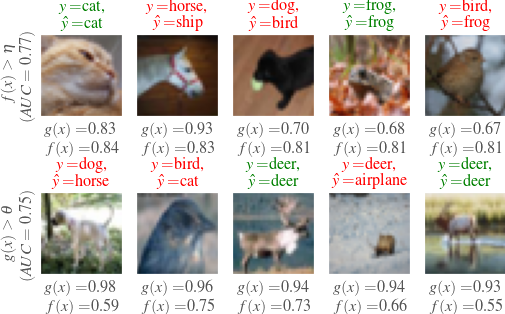

In [41]:
# Plot selected instances
# initialize the label 
labelNames = ['airplane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# X_test_best = X_test.reshape(-1,28,28)
# y_hat_best = y_test_pred_th[top_f_idx]
# y_th_best = np.argmax(y_test[top_f_idx], axis=1)
# Plot instances
row,col = 2,top_n
fig1, ax = plt.subplots(row, col, figsize=(6.0, 3.5), constrained_layout=True, dpi=90)
# fig1.subplots_adjust(wspace=0.1, hspace=0.35, top=0.5)
# for i in top_f_idx:
j = 0
for i,k in zip(top_f_idx, top_crit_idx):
    if np.argmax(y_test_best, axis=1)[i] != y_test_pred_th_best[i]:
        color = 'red'
    else:
        color = 'green'
    # ax = fig1.add_subplot(3, 4, j+1)
    ax[0][j].imshow(X_test_best[i, :, :, :])
    ax[0][j].set_title(r'$y=${s1}'.format(s1=labelNames[np.argmax(y_test_best, axis=1)[i]])+',\n'+\
                    r'$\hat{{y}}=${s2}'.format(s2=labelNames[y_test_pred_th_best[i]]), color=color, fontsize=13)
    ax[0][j].set_xlabel(r'$g(x)=${:.2f}'.format(crit_test[i])+'\n$f(x)=${:.2f}'.format(f_test[i]), fontsize=13)
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    if np.argmax(y_test_best, axis=1)[k] != y_test_pred_th_best[k]:
        color = 'red'
    else:
        color = 'green'
    # ax = fig1.add_subplot(3, 4, j+1)
    ax[1][j].imshow(X_test_best[k, :, :, :])
    ax[1][j].set_title(r'$y=${s1}'.format(s1=labelNames[np.argmax(y_test_best, axis=1)[k]])+',\n'+\
                    r'$\hat{{y}}=${s2}'.format(s2=labelNames[y_test_pred_th_best[k]]), color=color, fontsize=13)
    ax[1][j].set_xlabel(r"$g(x)=${:.2f}".format(crit_test[k])+'\n$f(x)=${:.2f}'.format(f_test[k]), fontsize=13)
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])
    j = j + 1
fig1.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0.01, wspace=-.5)
ax[0][0].set_ylabel(r"$f(x)>\eta$"+"\n"+r"$(AUC={:.2f})$".format(roc_f), fontsize=13)
# ax[0][0].set_ylabel(r"$f(x)>\eta$", fontsize=14)
ax[1][0].set_ylabel(r"$g(x)>\theta$"+"\n"+r"$(AUC={:.2f})$".format(roc_crit), fontsize=13)
# ax[1][0].set_ylabel(r"$g(x)>\theta$", fontsize=14)

# fig1.text(0.5, 0.01, r'$\rho={},~|f(x)>\eta|={},~|g(x)>\theta|={}$'.format(rho,np.sum(f_test>eta),np.sum(crit_test>theta)), ha='center', fontsize = 12)
# plt.suptitle(r'Top {} selected instances'.format(top_n), fontsize=15)
# plt.tight_layout()
# path_fig_fxgx_test = "drive/My Drive/NIPS2020/results/cifar10/fig_fxgx_test_{clf}_yhat{yhat}_pca{pca}.svg".format(clf=clf, pca=applyPCA, yhat=addPredictions)
# plt.savefig(path_fig_fxgx_test, bbox_inches='tight', facecolor='w')